## Bayesian fit for two component binding - simulated data - WITH EMCEE

In this notebook we see how well we can reproduce Kd from simulated experimental data with our Bayesian methods, these are the same as those used in the `quickmodel.py` script. We will be testing to see if sampling using the `emcee` library improves our equilibration time and ultimately, the results.


In [1]:
import numpy as np
import matplotlib.pyplot as plt

from scipy import optimize
import seaborn as sns

%pylab inline

Populating the interactive namespace from numpy and matplotlib


We use the same setup here as we do in the 'Simulating Experimental Fluorescence Binding Data' notebook.

In [2]:
# We define a Kd,
Kd = 2e-9 # M

# a protein concentration,
Ptot = 1e-9 * np.ones([12],np.float64) # M

# and a gradient of ligand concentrations for our experiment.
Ltot = 20.0e-6 / np.array([10**(float(i)/2.0) for i in range(12)]) # M

In [3]:
def two_component_binding(Kd, Ptot, Ltot):
    """
    Parameters
    ----------
    Kd : float
        Dissociation constant
    Ptot : float
        Total protein concentration
    Ltot : float
        Total ligand concentration
        
    Returns
    -------
    P : float
        Free protein concentration
    L : float
        Free ligand concentration
    PL : float
        Complex concentration
    """
                                    
    PL = 0.5 * ((Ptot + Ltot + Kd) - np.sqrt((Ptot + Ltot + Kd)**2 - 4*Ptot*Ltot))  # complex concentration (uM)
    P = Ptot - PL; # free protein concentration in sample cell after n injections (uM)                                                                                                                                                                                                                          
    L = Ltot - PL; # free ligand concentration in sample cell after n injections (uM)  
    
    return [P, L, PL]

In [4]:
[L, P, PL] = two_component_binding(Kd, Ptot, Ltot)

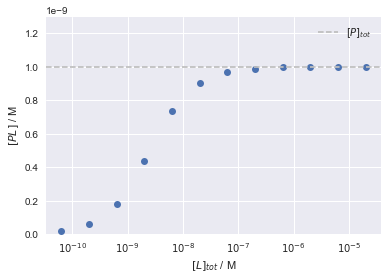

In [5]:
# y will be complex concentration
# x will be total ligand concentration
plt.semilogx(Ltot,PL, 'o')
plt.xlabel('$[L]_{tot}$ / M')
plt.ylabel('$[PL]$ / M')
plt.ylim(0,1.3e-9)
plt.axhline(Ptot[0],color='0.75',linestyle='--',label='$[P]_{tot}$')
plt.legend();

# Now make this a fluorescence experiment

In [6]:
# Making max 1400 relative fluorescence units, and scaling all of PL (complex concentration) 
# to that, adding some random noise
npoints = len(Ltot)
sigma = 10.0 # size of noise
F_PL_i = (1400/1e-9)*PL + sigma * np.random.randn(npoints)

/Users/hansons/anaconda2/lib/python2.7/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


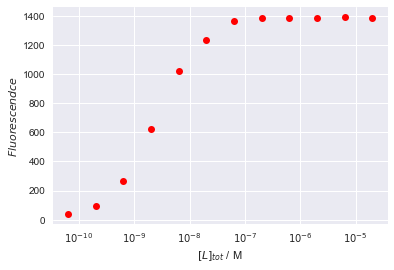

In [7]:
# y will be complex concentration
# x will be total ligand concentration
plt.semilogx(Ltot,F_PL_i, 'ro')
plt.xlabel('$[L]_{tot}$ / M')
plt.ylabel('$Fluorescendce$')
plt.legend();

In [8]:
#Let's add an F_background just so we don't ever go below zero
F_background = 40
#We also need to model fluorescence for our ligand
F_L_i = F_background + (.4/1e-8)*Ltot + sigma * np.random.randn(npoints)

#Let's also add these to our complex fluorescence readout
F_PL_i = F_background + ((1400/1e-9)*PL + sigma * np.random.randn(npoints)) + ((.4/1e-8)*L + sigma * np.random.randn(npoints))

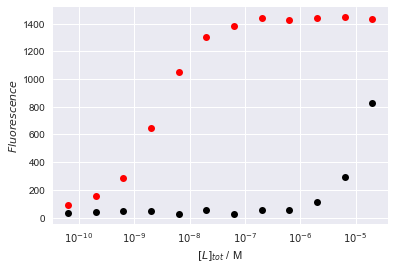

In [9]:
# y will be complex concentration
# x will be total ligand concentration
plt.semilogx(Ltot,F_PL_i, 'ro')
plt.semilogx(Ltot,F_L_i, 'ko')
plt.xlabel('$[L]_{tot}$ / M')
plt.ylabel('$Fluorescence$')
plt.legend();

In [10]:
# We know errors from our pipetting instruments.
P_error = 0.35
L_error = 0.08

assay_volume = 100e-6 # assay volume, L

dPstated = P_error * Ptot
dLstated = L_error * Ltot

In [11]:
# Now we'll use our Bayesian modeling scheme from assaytools.
from assaytools import pymcmodels
pymc_model = pymcmodels.make_model(Ptot, dPstated, Ltot, dLstated,
    top_complex_fluorescence=F_PL_i,
    top_ligand_fluorescence=F_L_i,
    use_primary_inner_filter_correction=True,
    use_secondary_inner_filter_correction=True,
    assay_volume=assay_volume, DG_prior='uniform')

/Users/hansons/anaconda2/lib/python2.7/site-packages/assaytools-0.2.0-py2.7.egg/assaytools/pymcmodels.py:70: RuntimeWarning: invalid value encountered in divide
  scaling = (1 - np.exp(-alpha)) / alpha


In [12]:
mcmc = pymcmodels.run_mcmc(pymc_model)

In [13]:
import matplotlib.patches as mpatches #this is for plotting with color patches

In [14]:
def mcmc_three_plots(pymc_model,mcmc,Lstated):

    sns.set(style='white')
    sns.set_context('talk')
    
    import pymbar
    [t,g,Neff_max] = pymbar.timeseries.detectEquilibration(mcmc.DeltaG.trace())
    
    interval= np.percentile(a=mcmc.DeltaG.trace()[t:], q=[2.5, 50.0, 97.5])
    [hist,bin_edges] = np.histogram(mcmc.DeltaG.trace()[t:],bins=40,normed=True)
    binwidth = np.abs(bin_edges[0]-bin_edges[1])

    #set colors for 95% interval
    clrs = [(0.7372549019607844, 0.5098039215686274, 0.7411764705882353) for xx in bin_edges]
    idxs = bin_edges.argsort()
    idxs = idxs[::-1]
    gray_before = idxs[bin_edges[idxs] < interval[0]]
    gray_after = idxs[bin_edges[idxs] > interval[2]]
    for idx in gray_before:
        clrs[idx] = (.5,.5,.5)
    for idx in gray_after:
        clrs[idx] = (.5,.5,.5)
    
    plt.clf();
    plt.figure(figsize=(12,3));

    plt.subplot(131)
    property_name = 'top_complex_fluorescence'
    complex = getattr(pymc_model, property_name)
    property_name = 'top_ligand_fluorescence'
    ligand = getattr(pymc_model, property_name)
    for top_complex_fluorescence_model in mcmc.top_complex_fluorescence_model.trace()[::10]:
        plt.semilogx(Lstated, top_complex_fluorescence_model, marker='.',color='silver')
    for top_ligand_fluorescence_model in mcmc.top_ligand_fluorescence_model.trace()[::10]:
        plt.semilogx(Lstated, top_ligand_fluorescence_model, marker='.',color='lightcoral', alpha=0.2)
    plt.semilogx(Lstated, complex.value, 'ko',label='complex')
    plt.semilogx(Lstated, ligand.value, marker='o',color='firebrick',linestyle='None',label='ligand')
    #plt.xlim(.5e-8,5e-5)
    plt.xlabel('$[L]_T$ (M)');
    plt.yticks([])
    plt.ylabel('fluorescence');
    plt.legend(loc=0);

    plt.subplot(132)
    plt.bar(bin_edges[:-1]+binwidth/2,hist,binwidth,color=clrs, edgecolor = "white");
    sns.kdeplot(mcmc.DeltaG.trace()[t:],bw=.4,color=(0.39215686274509803, 0.7098039215686275, 0.803921568627451),shade=False)
    plt.axvline(x=interval[0],color=(0.5,0.5,0.5),linestyle='--')
    plt.axvline(x=interval[1],color=(0.5,0.5,0.5),linestyle='--')
    plt.axvline(x=interval[2],color=(0.5,0.5,0.5),linestyle='--')
    plt.axvline(x=np.log(Kd),color='k')
    plt.xlabel('$\Delta G$ ($k_B T$)',fontsize=16);
    plt.ylabel('$P(\Delta G)$',fontsize=16);
    #plt.xlim(-15,-8)
    hist_legend = mpatches.Patch(color=(0.7372549019607844, 0.5098039215686274, 0.7411764705882353), 
        label = '$\Delta G$ =  %.3g [%.3g,%.3g] $k_B T$' 
        %(interval[1],interval[0],interval[2]) )
    plt.legend(handles=[hist_legend],fontsize=10,loc=0,frameon=True);

    plt.subplot(133)
    plt.plot(range(0,t),mcmc.DeltaG.trace()[:t], 'g.',label='equil. at %s'%t)
    plt.plot(range(t,len(mcmc.DeltaG.trace())),mcmc.DeltaG.trace()[t:], '.')
    plt.xlabel('MCMC sample');
    plt.ylabel('$\Delta G$ ($k_B T$)');
    plt.legend(loc=2);

    plt.tight_layout();
    
    return [t,interval,hist,bin_edges,binwidth]

In [15]:
Kd

2e-09

In [16]:
print 'Real Kd is 2nm or %s k_B T.' %np.log(Kd)

Real Kd is 2nm or -20.0301186564 k_B T.


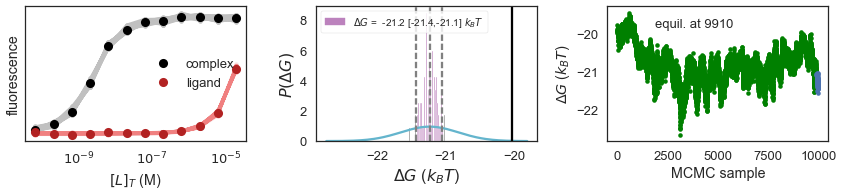

In [17]:
[t,interval,hist,bin_edges,binwidth] = mcmc_three_plots(pymc_model,mcmc,Ltot)

That works, but the equilibration seems to happen quite late in our sampling! Let's look at some of the other parameters.

In [18]:
well_area = 0.1586 # well area, cm^2 # half-area wells were used here
path_length = assay_volume / well_area

/Users/hansons/anaconda2/lib/python2.7/site-packages/assaytools-0.2.0-py2.7.egg/assaytools/plots.py:253: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  plt.hold(True)
/Users/hansons/anaconda2/lib/python2.7/site-packages/matplotlib/__init__.py:917: UserWarning: axes.hold is deprecated. Please remove it from your matplotlibrc and/or style files.
  warnings.warn(self.msg_depr_set % key)
/Users/hansons/anaconda2/lib/python2.7/site-packages/matplotlib/rcsetup.py:152: UserWarning: axes.hold is deprecated, will be removed in 3.0
  warnings.warn("axes.hold is deprecated, will be removed in 3.0")
/Users/hansons/anaconda2/lib/python2.7/site-packages/assaytools-0.2.0-py2.7.egg/assaytools/plots.py:290: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot comman

(10000,)


/Users/hansons/anaconda2/lib/python2.7/site-packages/assaytools-0.2.0-py2.7.egg/assaytools/plots.py:378: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  plt.hold(True);
/Users/hansons/anaconda2/lib/python2.7/site-packages/assaytools-0.2.0-py2.7.egg/assaytools/plots.py:396: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  plt.hold(True)
/Users/hansons/anaconda2/lib/python2.7/site-packages/assaytools-0.2.0-py2.7.egg/assaytools/plots.py:413: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  plt.hold(False)


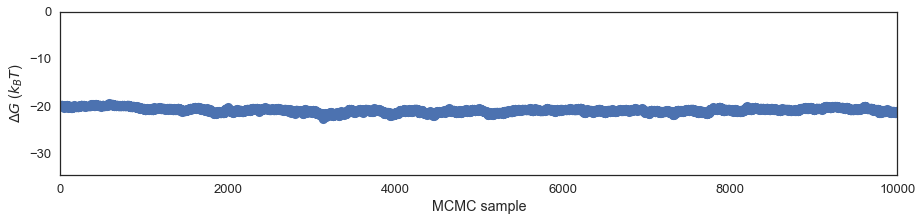

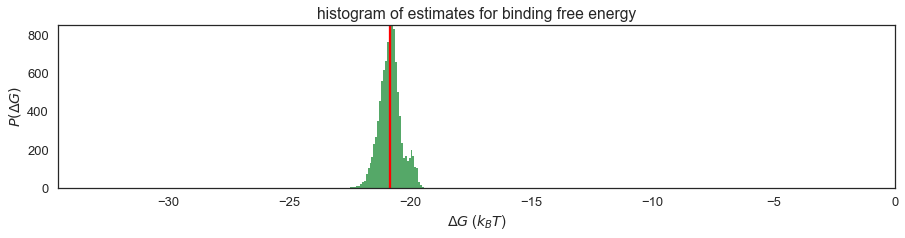

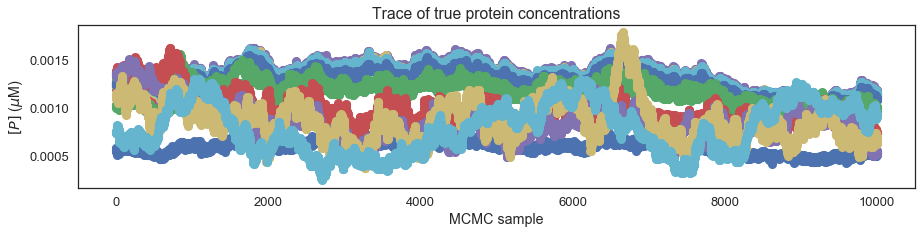

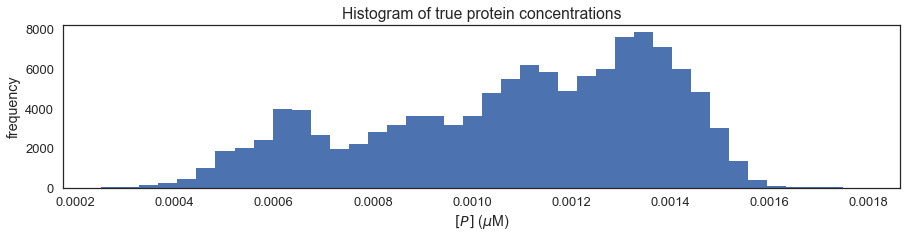

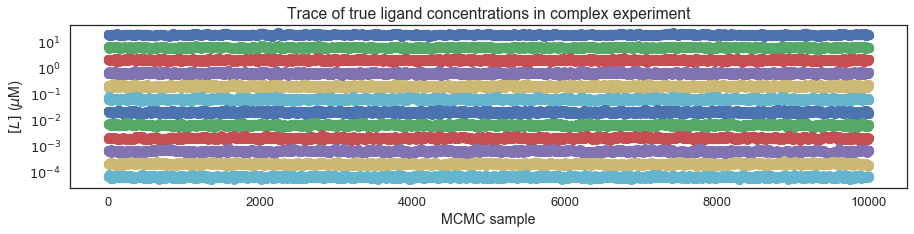

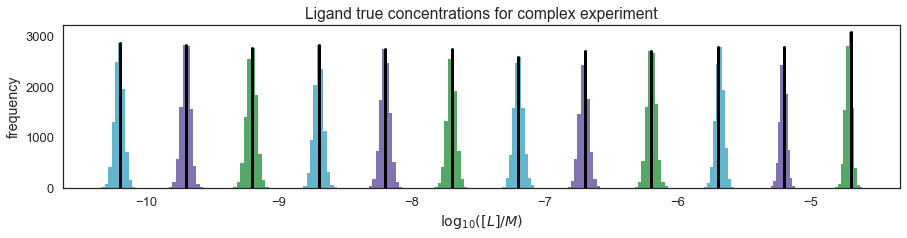

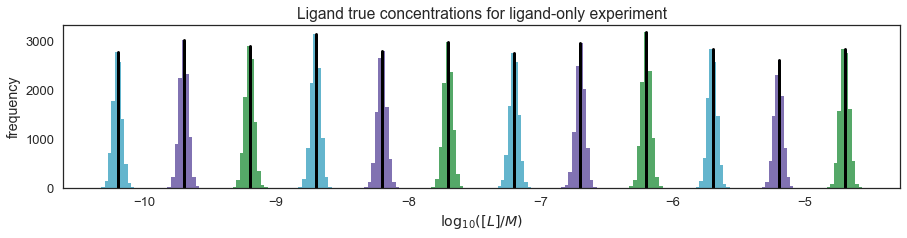

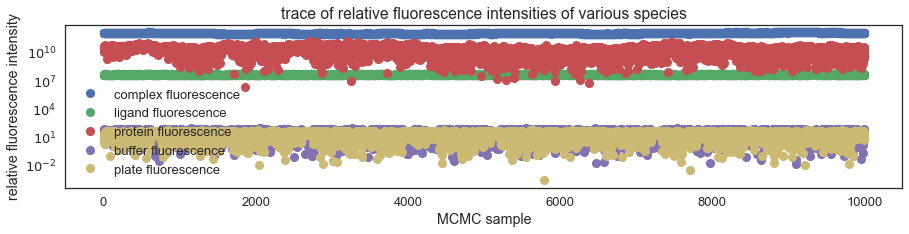

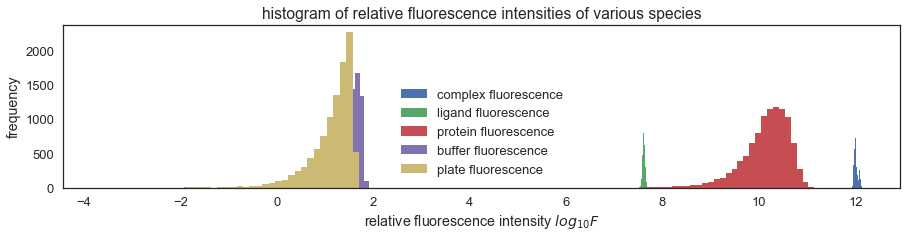

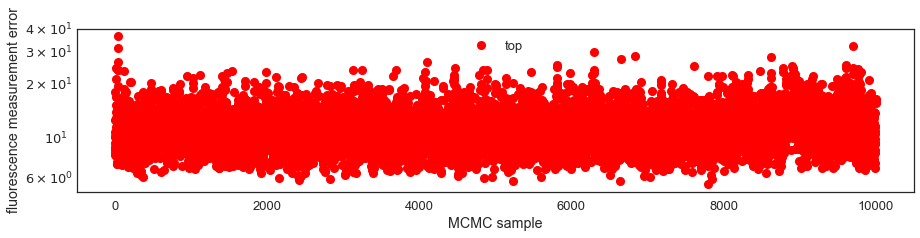

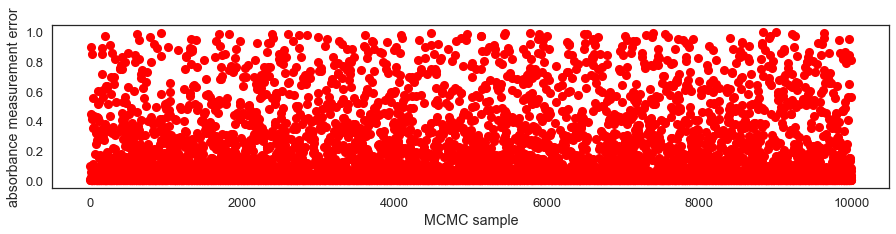

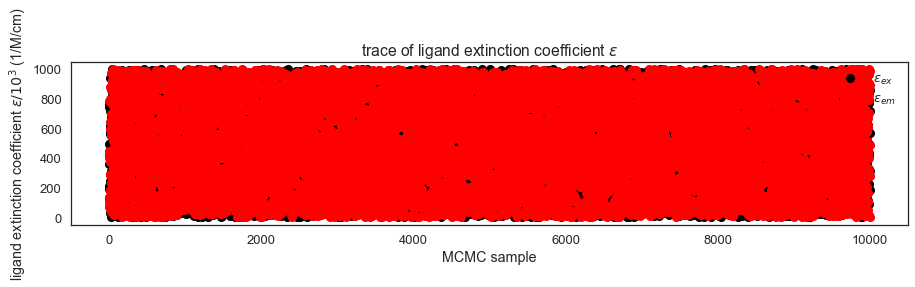

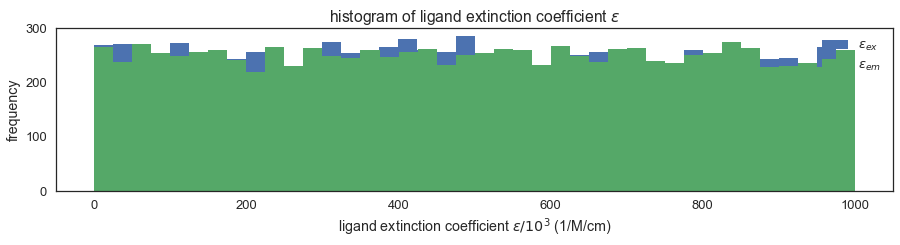

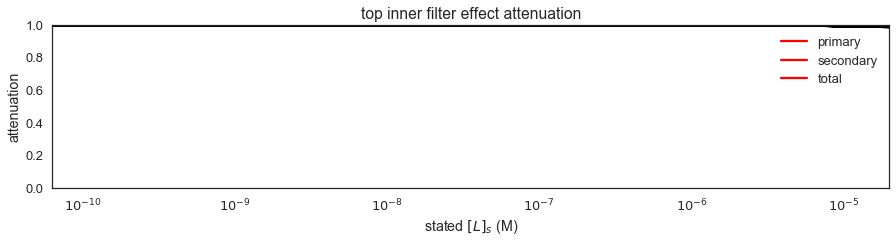

In [19]:
from assaytools import plots
plots.plot_mcmc_results(Ltot, Ptot, path_length, mcmc)

### Now let's see if we can get better results using the newly implemented emcee option.

Following instructions as described here: http://twiecki.github.io/blog/2013/09/23/emcee-pymc/

In [12]:
mcmc_emcee = pymcmodels.run_mcmc_emcee(pymc_model)

/Users/hansons/anaconda2/lib/python2.7/site-packages/assaytools-0.2.0-py2.7.egg/assaytools/bindingmodels.py:84: RuntimeWarning: invalid value encountered in log
  logL = np.log(Ltot)
/Users/hansons/anaconda2/lib/python2.7/site-packages/assaytools-0.2.0-py2.7.egg/assaytools/bindingmodels.py:88: RuntimeWarning: invalid value encountered in less
  sqrt_arg[sqrt_arg < 0.0] = 0.0 # ensure always positive
/Users/hansons/anaconda2/lib/python2.7/site-packages/assaytools-0.2.0-py2.7.egg/assaytools/bindingmodels.py:102: RuntimeWarning: invalid value encountered in less
  PL[PL < 0.0] = 0.0 # complex cannot have negative concentration
/Users/hansons/anaconda2/lib/python2.7/site-packages/assaytools-0.2.0-py2.7.egg/assaytools/pymcmodels.py:72: RuntimeWarning: invalid value encountered in less
  indices = np.where(np.abs(alpha) < 0.01)
/Users/hansons/anaconda2/lib/python2.7/site-packages/assaytools-0.2.0-py2.7.egg/assaytools/bindingmodels.py:83: RuntimeWarning: invalid value encountered in log
  log

emcee: Exception while calling your likelihood function:
  params: [  1.49495038e+01   1.13590015e+00  -1.32827179e+00   1.19135817e+12
  -2.03637830e+01   2.71093253e+10  -1.67421620e-01   3.89760615e+07
   2.01226150e+00   7.64676702e-01   7.00493313e+04   5.09504975e+01
   3.62823245e+01]
  args: []
  kwargs: {}
  exception:


error: (ntau==1||ntau==n) failed for hidden ntau: lognormal:ntau=12